# Week 4: Project
This notebook presents the final project of the author in the **Meaning Predictive Modeling** course offered by Coursera. 

The dataset analysed in this workbook was obtained from another Coursera course that the author is enrolled in, namely **Data Management and Visualization** by Wesleyan University (https://www.coursera.org/learn/data-visualization/supplement/F0UbG/course-data-sets). 

If the reader is interested, more information is available at https://www.gapminder.org/.

## GapMinder Dataset Description
**GapMinder** is a non-profit venture founded in Stockholm by *Ola Rosling*, *Anna Rosling Rönnlund* and *Hans Rosling*, which aims to **promote sustainable global development and achievement** of the *United Nations Millennium Development Goals*. It seeks to increase the use and understanding of statistics about social, economic, and environmental development at local, national, and global levels. 

Since its conception in 2005, Gapminder has grown to include over 200 indicators, including gross domestic product, total employment rate, and estimated HIV prevalence. Gapminder contains data for all 192 UN members, aggregating data for Serbia and Montenegro. Additionally, it includes data for 24 other areas, generating a total of 215 areas. 
   
GapMinder collects data from a handful of sources, including the *Institute for Health Metrics and Evaulation*, *US Census Bureau’s International Database*, *United Nations Statistics Division*, and the *World Bank*. 
   
This portion of the GapMinder data includes one year of numerous country-level indicators of health, wealth and development. Each entry is uniquely identified by their country name. The aim of the project is to predict the residential electricity consumption per person from other measurable variables, specifically alcohol consumption and urban population as these are the only two variables collected on the same year.

Below is the dataset description from the GapMinder Codebook (https://d396qusza40orc.cloudfront.net/phoenixassets/data-management-visualization/GapMinder%20Codebook%20.pdf):

|	Name					|	Data Type	|	Measure				|	Description																	|
|	--------------------	|	----------	|	----------------	|	------------------------------------------------------------------------	|
|	incomeperperson			|	continuous	|	US$					|	2010 gross domestic product per capita with inflation taken into account	|
|	*alcconsumption*		|	continuous	|	litres				|	2008 alcohol consumption per adult (age 15+)								|
|	armedforcesrate			|	continuous	|	\%					|	percentage of armed forces personnel of total labor force					|
|	breastcancerper100TH	|	continuous	|	rate				|	2002 breast cancer new cases per 100,000 female								|
|	co2emissions			|	continuous	|	metric tons			|	2006 cumulative CO2 emission since 1751										|
|	femaleemployrate		|	continuous	|	\% of population	|	2007 percentage of adult female employed 									|
|	HIVrate					|	continuous	|	\%					|	2009 estimated HIV prevalence (Ages 15-49)									|
|	Internetuserate			|	continuous	|	rate				|	2010 Internet users per 100 people											|
|	lifeexpectancy			|	continuous	|	years				|	2011 life expectancy at birth												|
|	oilperperson			|	continuous	|	tonnes				|	2010 oil consumption per capita												|
|	polityscore				|	integer		|	polity				|	2009 overall polity score from -10 to 10 (overall = autocracy - democracy)	|
|	*relectricperperson*	|	continuous	|	kWh					|	2008 residential electricity consumption per person							|
|	suicideper100TH			|	continuous	|	rate				|	2005 suicide per 100,000 people (age adjusted)								|
|	employrate				|	continuous	|	\% of population	|	2007 percentage of adult employed 											|
|	*urbanrate*				|	continuous	|	\% of population	|	2008 urban population														|

## Data Preparation and Cleaning
Some data are missing in the dataset. Since all of the variables are numerical, the missing data could be replaced by zeros to allow the calculation of statistics later on. 

However, for the computation of correlation scores between the variables, the number of data points for each variable has to be the same. Therefore, the countries with missing data of interest, namely *alcconsumption*, *relectricperperson* and *urbanrate*, are eliminated from the dataset.

In [12]:
# Import useful libraries
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from collections import defaultdict
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error

In [3]:
# Load the GapMinder dataset
f = open("./gapminder.csv")
all_lines = list(csv.reader(f, delimiter = ','))

headers = all_lines[0]  # Extract the headers
dataset = []
for line in all_lines[1:]:
    d = dict(zip(headers, line))
    for header in headers[1:]:
        if ' ' not in d[header]: d[header] = float(d[header])  # Cast the numerical values to float type
        else: d[header] = np.nan
    if d['alcconsumption'] != np.nan and d['relectricperperson'] != np.nan and d['urbanrate'] != np.nan:  # Filter out countries with no data of interest
        dataset.append(d)
    
# Create a dataframe from the dataset
variables_of_interest = ['country', 'alcconsumption', 'relectricperperson', 'urbanrate']
data = pd.DataFrame(dataset)[variables_of_interest]
data.set_index('country', inplace=True)

# Check for missing values
print("Total number of entries: {0}\n".format(len(data)))
print("Number of missing data in variables:")
print("alcconsumption: {0}".format(data['alcconsumption'].isnull().sum()))
print("relectricperperson: {0}".format(data['relectricperperson'].isnull().sum()))
print("urbanrate: {0}".format(data['urbanrate'].isnull().sum()))

# First 5 rows
data.head()

Total number of entries: 213

Number of missing data in variables:
alcconsumption: 26
relectricperperson: 77
urbanrate: 10


,alcconsumption,relectricperperson,urbanrate
country,,,
Afghanistan,0.03,NaN,24.04
Albania,7.29,636.341383,46.72
Algeria,0.69,590.509814,65.22
Andorra,10.17,NaN,88.92
Angola,5.57,172.999227,56.70


Since all of the variables of interest contain missing values, it is important to figure out the best way to handle them. My first step is to briefly examine their distribution using frequency tables. The continuous quantitative data are binned into equal quartiles for this purpose.

Since the urbanrate variable has the least missing data, I decided to discard the entries without urbanrate data and fill in the missing values in both consumption variables based on their quartile in urbanrate. The values that are used to fill in the missing spots are the medians of the other countries belonging to the same subgroup quartile as the country with missing data.

As the distribution of both consumption variables seem to be right-skewed, median is chosen instead of mean due to its greater resistence towards influence of outliers.

In [4]:
# Investigate frequency distributions of raw data
data['alcpa (litre)'] = pd.qcut(data['alcconsumption'], 4, labels=[1, 2, 3, 4])
alc_val_count = data.groupby('alcpa (litre)').size()
alc_dist = data['alcpa (litre)'].value_counts(sort=False, dropna=True, normalize=True)
alc_freq_tab = pd.concat([alc_val_count, alc_dist], axis=1)
alc_freq_tab.columns = ['value_count', 'frequency']
print("Frequency table of alcohol consumption per adult:\n{0}\n".format(alc_freq_tab))

data['relectricpp (kWh)'] = pd.qcut(data['relectricperperson'], 4, labels=[1, 2, 3, 4])  # Variable range is extended by 0.1%
elec_val_count = data.groupby('relectricpp (kWh)').size()
elec_dist = data['relectricpp (kWh)'].value_counts(sort=False, dropna=True, normalize=True)
elec_freq_tab = pd.concat([elec_val_count, elec_dist], axis=1)
elec_freq_tab.columns = ['value_count', 'frequency']
print("Frequency table of residential electricity consumption per person:\n{0}\n".format(elec_freq_tab))

data['urbanr (%)'] = pd.qcut(data['urbanrate'], 4, labels=[1, 2, 3, 4])
urb_val_count = data.groupby('urbanr (%)').size()
urb_dist = data['urbanr (%)'].value_counts(sort=False, dropna=True, normalize=True)
urb_freq_tab = pd.concat([urb_val_count, urb_dist], axis=1)
urb_freq_tab.columns = ['value_count', 'frequency']
print("Frequency table of urban population:\n{0}\n".format(urb_freq_tab))

# Code in valid data in place of missing data for each variable
data = data[data['urbanrate'].notnull()]

null_alc_data = data[data['alcconsumption'].isnull()].copy()
alc_map_dict = data.groupby('urbanr (%)').median()['alcconsumption'].to_dict()
print("Median values of alcconsumption corresponding to each urbanrate group:\n{0}\n".format(alc_map_dict))
null_alc_data['alcconsumption'] = null_alc_data['urbanr (%)'].map(alc_map_dict)
data = data.combine_first(null_alc_data)
data['alcpa (litre)'] = pd.qcut(data['alcconsumption'], 4, labels=[1, 2, 3, 4])

null_elec_data = data[data['relectricperperson'].isnull()].copy()
elec_map_dict = data.groupby('urbanr (%)').median()['relectricperperson'].to_dict()
print("Median values of relectricperperson corresponding to each urbanrate group:\n{0}\n".format(elec_map_dict))
null_elec_data['relectricperperson'] = null_elec_data['urbanr (%)'].map(elec_map_dict)
data = data.combine_first(null_elec_data)
data['relectricpp (kWh)'] = pd.qcut(data['relectricperperson'], 4, labels=[1, 2, 3, 4])

data.head()

Frequency table of alcohol consumption per adult:
   value_count  frequency
1           47   0.251337
2           47   0.251337
3           46   0.245989
4           47   0.251337

Frequency table of residential electricity consumption per person:
   value_count  frequency
1           34       0.25
2           34       0.25
3           34       0.25
4           34       0.25

Frequency table of urban population:
   value_count  frequency
1           51   0.251232
2           51   0.251232
3           50   0.246305
4           51   0.251232

Median values of alcconsumption corresponding to each urbanrate group:
{1: 3.76, 2: 5.56, 3: 8.84, 4: 8.65}

Median values of relectricperperson corresponding to each urbanrate group:
{1: 120.381648883129, 2: 297.883200408304, 3: 758.858719204085, 4: 1689.08873449487}



,alcconsumption,relectricperperson,urbanrate,alcpa (litre),relectricpp (kWh),urbanr (%)
country,,,,,,
Afghanistan,0.03,120.381649,24.04,1,1,1
Albania,7.29,636.341383,46.72,3,3,2
Algeria,0.69,590.509814,65.22,1,3,3
Andorra,10.17,1689.088734,88.92,4,4,4
Angola,5.57,172.999227,56.70,2,2,2


## Simple Statistics
It is paramount to check out some simple statistics of the variables of interest prior to further analyses of the data. Now that the missing data have been handled and dataset is cleaned, some of the statistics are computed below.

The mean value and range of each variable has been explored. The countries with corresponding maximum and minimum values of each variable are also investigated. However, it is hard to deduce the relationships between these variables without visualizing them at this stage.

In [5]:
alc_desc = data['alcconsumption'].astype('float').describe()
elec_desc = data['relectricperperson'].describe()
urb_desc = data['urbanrate'].describe()

print(f"Total number of countries in dataset: {len(data)}\n")
print(f"Average alcohol consumption per person over all countries: {alc_desc['mean']} litres")
print(f"Highest alcohol consumption per person: {alc_desc['max']} litres")
print(f"Country with the highest alcohol consumption per person: {data[data['alcconsumption'] == alc_desc['max']].index[0]}")
print(f"Lowest alcohol consumption per person: {alc_desc['min']} litres")
print(f"Country with the lowest alcohol consumption per person: {data[data['alcconsumption'] == alc_desc['min']].index[0]}")
print(f"Average residential electricity consumption per person over all countries: {elec_desc['mean']} kWh")
print(f"Maximum residential electricity consumption per person: {elec_desc['max']} kWh")
print(f"Country with the highest residential electricity consumption per person: {data[data['relectricperperson'] == elec_desc['max']].index[0]}")
print(f"Minimum residential electricity consumption per person: {elec_desc['min']} kWh")
print(f"Country with the lowest residential electricity consumption per person: {data[data['relectricperperson'] == elec_desc['min']].index[0]}\n")
print(f"Average urban population over all countries: {urb_desc['mean']} %")
print(f"Highest urban population: {urb_desc['max']} %")
print(f"Country with the highest urban population: {data[data['urbanrate'] == urb_desc['max']].index[0]}")
print(f"Lowest urban population: {urb_desc['min']} %")
print(f"Country with the lowest urban population: {data[data['urbanrate'] == urb_desc['min']].index[0]}\n")

Total number of countries in dataset: 203

Average alcohol consumption per person over all countries: 6.8411330049261085 litres
Highest alcohol consumption per person: 23.01 litres
Country with the highest alcohol consumption per person: Moldova
Lowest alcohol consumption per person: 0.03 litres
Country with the lowest alcohol consumption per person: Afghanistan
Average residential electricity consumption per person over all countries: 960.6229349598966 kWh
Maximum residential electricity consumption per person: 11154.7550328078 kWh
Country with the highest residential electricity consumption per person: United Arab Emirates
Minimum residential electricity consumption per person: 0.0 kWh
Country with the lowest residential electricity consumption per person: Iraq

Average urban population over all countries: 56.76935960591133 %
Highest urban population: 100.0 %
Country with the highest urban population: Bermuda
Lowest urban population: 10.4 %
Country with the lowest urban population: B

## Data Visualizations
The distributions of the data for the three variables are visualized using histograms as they are all numeric continuous variables. The histograms also enable the central tendency and skewness of the data to be shown clearly. Box plots are then used to mark the outliers.

The relationships between the variables are then visualized using scatter plots. The correlations are calculated and displayed on the graphs for easier reference.

### Data Distribution
It is concluded from the histograms that the residential electricity consumption per person and alcohol consumption per person are strongly skewed to the right while the urban population roughly follows a normal distribution which peaks around urban population of 65%.

The boxplots allows the identification of the outliers in the residential electricity consumption per person and alcohol consumption per person data. No data point is found to lie outside 1.5 * the interquartile range for the urban population variable. Note that a log scale was used for the plotting of residential electricity consumption per person due to the large order of magnitude in differences between the minimum and maximum of the variable. This allows clearer presentation of all points in the boxplot.

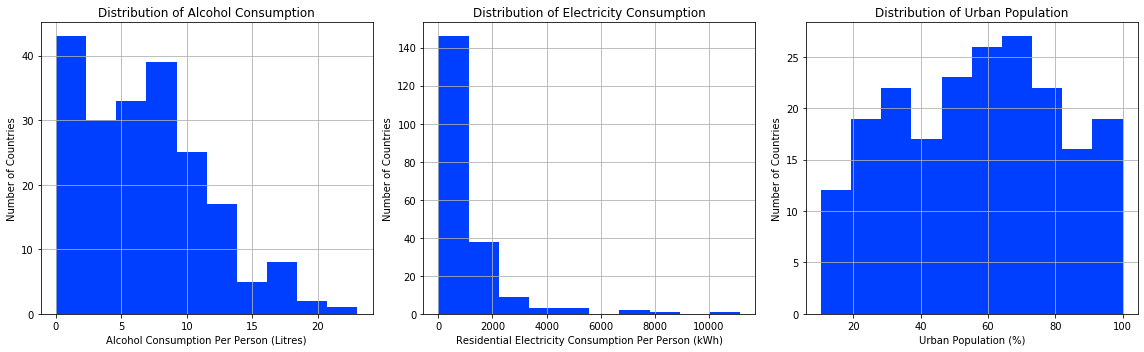

In [6]:
# Plot the histograms
style.use('seaborn-bright')
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.gca().set(xlabel='Alcohol Consumption Per Person (Litres)', ylabel='Number of Countries', title='Distribution of Alcohol Consumption')
plt.grid()
plt.hist(data['alcconsumption'])
plt.subplot(1, 3, 2)
plt.gca().set(xlabel='Residential Electricity Consumption Per Person (kWh)', ylabel='Number of Countries', title='Distribution of Electricity Consumption')
plt.grid()
plt.hist(data['relectricperperson'])
plt.subplot(1, 3, 3)
plt.gca().set(xlabel='Urban Population (%)', ylabel='Number of Countries', title='Distribution of Urban Population')
plt.grid()
plt.hist(data['urbanrate'])
plt.tight_layout()
plt.show()

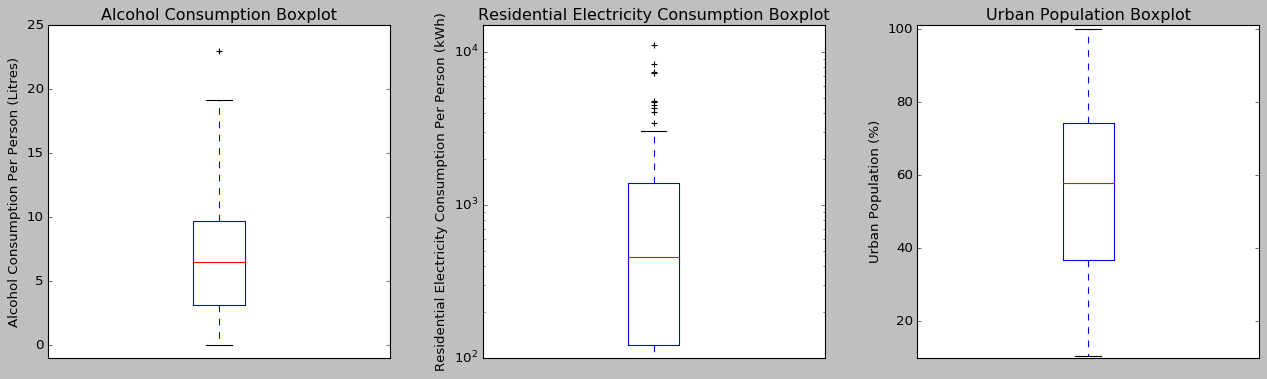

In [7]:
# Plot the box plots
style.use('classic')
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.boxplot(data['alcconsumption'])
plt.xticks([])
plt.ylim(-1, None)
plt.gca().set(ylabel='Alcohol Consumption Per Person (Litres)', title='Alcohol Consumption Boxplot')
plt.subplot(1, 3, 2)
plt.boxplot(data['relectricperperson'])
plt.xticks([])
plt.yscale('log')
plt.ylim(None, 15000)
plt.gca().set(ylabel='Residential Electricity Consumption Per Person (kWh)', title='Residential Electricity Consumption Boxplot')
plt.subplot(1, 3, 3)
plt.boxplot(data['urbanrate'])
plt.xticks([])
plt.ylim(None, 101)
plt.gca().set(ylabel='Urban Population (%)', title='Urban Population Boxplot')
plt.tight_layout()
plt.show()

### Data Correlation

The scatterplots clearly show that both urban population and alcohol consumption are positively correlated with the residential electricity consumption, with the correlation between urban population and residential electricity consumption being much stronger. In fact, alcohol consumption is only slightly correlated with the electricity consumption, as seen from the small magnitude of the correlation.

On a side note, alcohol consumption and urban population are also found to be slightly positively correlated. This could perhaps be explained by greater need for alcohol and greater buying power of the residents in the urban area.

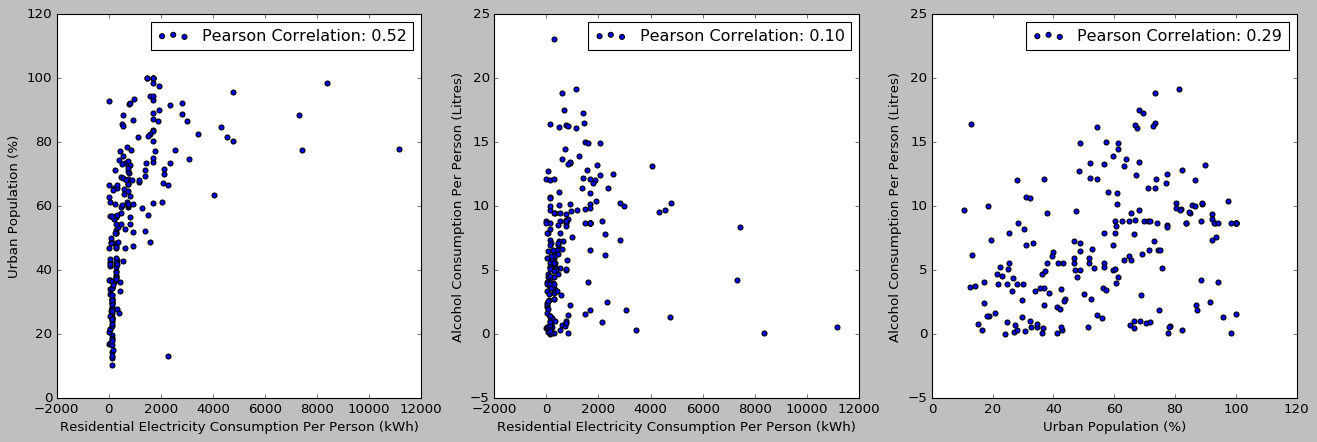

In [8]:
# Compute the Pearson's correlation scores
elec_urban_corr = pearsonr(data['relectricperperson'], data['urbanrate'])
elec_alc_corr = pearsonr(data['relectricperperson'], data['alcconsumption'])
urban_alc_corr = pearsonr(data['urbanrate'], data['alcconsumption'])

# Graph the scatter plots 
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.gca().set(xlabel='Residential Electricity Consumption Per Person (kWh)', ylabel='Urban Population (%)')
plt.scatter(data['relectricperperson'], data['urbanrate'], label='Pearson Correlation: {0:.2f}'.format(elec_urban_corr[0]))
plt.legend()
plt.subplot(1, 3, 2)
plt.gca().set(xlabel='Residential Electricity Consumption Per Person (kWh)', ylabel='Alcohol Consumption Per Person (Litres)')
plt.scatter(data['relectricperperson'], data['alcconsumption'], label='Pearson Correlation: {0:.2f}'.format(elec_alc_corr[0]))
plt.legend()
plt.subplot(1, 3, 3)
plt.gca().set(xlabel='Urban Population (%)', ylabel='Alcohol Consumption Per Person (Litres)')
plt.scatter(data['urbanrate'], data['alcconsumption'], label='Pearson Correlation: {0:.2f}'.format(urban_alc_corr[0]))
plt.legend()

## Basic Operations

Regressions and classifications were performed on the variables. The classification models include *logistic regression classifier*, *K-nearest neighbor classifier*, and *support vector classifier*. On the other hand, only a ridge regressor model was created to carry out the regression. Validation data are employed to choose the best hyperparameters of each model. The hyperparameters that were varied are *C*, *n_neighbors*, *C*, and *alpha* for logistic regression classifier, K-nearest neighbor classifier, support vector classifier and ridge regressor, respectively.

The classifications were done on the binned frequency distribution variables created earlier while the regression was carried out on the continuous quantitative data that are first normalized.

The training set was set to 60% of the total number of entries, which means around 120 entries. The remainder entries were split equally to be used as validation set to optimize the models and test set to evaluate the best models chosen.

### Classification
The evaluation of the classification models reveals that logistic regression classifier with C=1 and K-nearest neighbors classifier with K=6 performed equally well while support vector classfier with C=1 outperforms them. 

The support vector classifier performs slightly worse on test set compared to validation set while the rest of the classifiers exhibited similar performance and therefore no overfitting is observed. However, the accuracy is not satisfactorily high as only about 70% of the data are predicted correclty. This might be due to the lack of complexity of the model as only 2 features are being used. The models are thus said to be seriously underfitting. Adding more features could potentially mitigate the issue.

It might seem suspicious that the logistic regression classifier and K-nearest neighbors are reporting similar performance. However, when the classification reports were investigated closely, it could be seen that the models actually achieve different prediction performance on different classes. It seems to be purely coincidence that the overall average of the accuracy appears the same.

### Regression
Ridge regressor with alpha=0.1 was found to perform the best on the regression problem. The mean squared error (MSE) computed on the test set is about twice of the MSE obtained during validation even though it is still considered very small in magnitude. 

The magnitude of the coefficients of the features shows that alcohol consumption per adult is not really contributing to the variance in residential electricity consumption per person, which is in alignment with the findings from the previous sections.

Lastly, the R2 score of the best ridge regressor was found to be very close to 0. This could be indicating that the model is also consistently predicting the expected value of the data for the new unseen data, which could be due to lack of training data and imbalanced dataset.

In [24]:
# Scale the contiuous quantitative data
data['alcconsumption'] = MinMaxScaler().fit_transform(np.array(data['alcconsumption']).reshape(-1, 1))
data['relectricperperson'] = MinMaxScaler().fit_transform(np.array(data['relectricperperson']).reshape(-1, 1))
data['urbanrate'] = MinMaxScaler().fit_transform(np.array(data['urbanrate']).reshape(-1, 1))

# Prepare training, validation and testing set
X_variables_cls, y_variable_cls = ['urbanr (%)', 'alcpa (litre)'], 'relectricpp (kWh)'
X_variables_reg, y_variable_reg = ['urbanrate', 'alcconsumption'], 'relectricperperson'
X_train_cls, X_test_val_cls, y_train_cls, y_test_val_cls = train_test_split(data[X_variables_cls], data[y_variable_cls], test_size=0.4, random_state=0)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(X_test_val_cls, y_test_val_cls, test_size=0.5, random_state=0)
X_train_reg, X_test_val_reg, y_train_reg, y_test_val_reg = train_test_split(data[X_variables_reg], data[y_variable_reg], test_size=0.4, random_state=0)
X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(X_test_val_reg, y_test_val_reg, test_size=0.5, random_state=0)

# Choose the best models
logreg_C, knn_n, svc_C, ridge_a = [0.1, 1, 10], [4, 5, 6], [0.1, 1, 10], [0.1, 1, 10]
best_scores, best_models = [0, 0, 0, 100], [None, None, None, None]
for i in range(len(logreg_C)):
    
    # Creating classification and regression models
    logreg_clf = LogisticRegression(C=logreg_C[i], random_state=0)
    knn_clf = KNeighborsClassifier(n_neighbors=knn_n[i])
    svc_clf = SVC(C=svc_C[i])
    ridreg = Ridge(alpha=0.1) 

    # Training data
    logreg_clf.fit(X_train_cls, y_train_cls)
    knn_clf.fit(X_train_cls, y_train_cls)
    svc_clf.fit(X_train_cls, y_train_cls)
    ridreg.fit(X_train_reg, y_train_reg)

    # Predicting outcome on validation set
    logreg_pred = logreg_clf.predict(X_val_cls)
    knn_pred = knn_clf.predict(X_val_cls)
    svc_pred = svc_clf.predict(X_val_cls)
    ridreg_pred = ridreg.predict(X_val_reg)
    
    # Compare the models based on accuracy (classification) or MSE (regression)
    if accuracy_score(y_val_cls, logreg_pred) > best_scores[0]: best_scores[0], best_models[0] = accuracy_score(y_val_cls, logreg_pred), logreg_clf
    if accuracy_score(y_val_cls, knn_pred) > best_scores[1]: best_scores[1], best_models[1] = accuracy_score(y_val_cls, knn_pred), knn_clf
    if accuracy_score(y_val_cls, svc_pred) > best_scores[2]: best_scores[2], best_models[2] = accuracy_score(y_val_cls, svc_pred), svc_clf
    if mean_squared_error(y_val_reg, ridreg_pred) < best_scores[3]: best_scores[3], best_models[3] = mean_squared_error(y_val_reg, ridreg_pred), ridreg

 # Predicting outcome on testing set
logreg_pred = best_models[0].predict(X_test_cls)
knn_pred = best_models[1].predict(X_test_cls)
svc_pred = best_models[2].predict(X_test_cls)
ridreg_pred = best_models[3].predict(X_test_reg)
    
# Evaluating the classification models
print("Best logistic regression classifier hyperparameters: {0} with validation accuracy {1}".format(best_models[0], best_scores[0]))
print("Best K-nearest neighbor classifier hyperparameters: {0} with validation accuracy {1}".format(best_models[1], best_scores[1]))
print("Best support vector classifier hyperparameters: {0} with validation accuracy {1}\n".format(best_models[2], best_scores[2]))

print("Best logistic regression classifier test accuracy: {0}".format(accuracy_score(y_test_cls, logreg_pred)))
print("Best K-nearest neighbor classifier test accuracy: {0}".format(accuracy_score(y_test_cls, knn_pred)))
print("Best support vector classifier test accuracy: {0}\n".format(accuracy_score(y_test_cls, svc_pred)))

print("Best logistic regression classifier confusion matrix:\n{0}".format(confusion_matrix(y_test_cls, logreg_pred)))
print("Best K-nearest neighbor classifier confusion matrix:\n{0}".format(confusion_matrix(y_test_cls, knn_pred)))
print("Best support vector classifier confusion matrix:\n{0}\n".format(confusion_matrix(y_test_cls, svc_pred)))

print("Best logistic regression classifier classification report:\n{0}".format(classification_report(y_test_cls, logreg_pred)))
print("Best K-nearest neighbor classifier classification report:\n{0}".format(classification_report(y_test_cls, knn_pred)))
print("Best support vector classifier classification report:\n{0}".format(classification_report(y_test_cls, svc_pred)))

# Evaluating the regression model
print("Best ridge regressor hyperparameters: {0} with validation MSE {1}".format(best_models[3], best_scores[3]))
print("Best ridge regressor test MSE: {0}".format(mean_squared_error(y_test_reg, ridreg_pred)))
print('Best ridge regressor intercept: ', best_models[3].intercept_)
print('Best ridge regressor coefficients: ', best_models[3].coef_)
print("Best ridge regressor R2 score: {0}".format(r2_score(y_test_reg, ridreg_pred)))

Best logistic regression classifier hyperparameters: LogisticRegression(C=1, random_state=0) with validation accuracy 0.6341463414634146
Best K-nearest neighbor classifier hyperparameters: KNeighborsClassifier(n_neighbors=6) with validation accuracy 0.6341463414634146
Best support vector classifier hyperparameters: SVC(C=1) with validation accuracy 0.7073170731707317

Best logistic regression classifier test accuracy: 0.6341463414634146
Best K-nearest neighbor classifier test accuracy: 0.6341463414634146
Best support vector classifier test accuracy: 0.6829268292682927

Best logistic regression classifier confusion matrix:
[[ 6  2  1  0]
 [ 1  6  6  0]
 [ 0  0  4  5]
 [ 0  0  0 10]]
Best K-nearest neighbor classifier confusion matrix:
[[8 0 1 0]
 [2 5 6 0]
 [0 0 8 1]
 [0 0 5 5]]
Best support vector classifier confusion matrix:
[[6 2 1 0]
 [1 6 6 0]
 [0 0 7 2]
 [0 0 1 9]]

Best logistic regression classifier classification report:
              precision    recall  f1-score   support

  